In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
#!pip install chromadb
#!pip install sentence-transformers
#!pip install langchain openai

In [4]:
import matplotlib.pyplot as plt

In [5]:
import os, sys
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

import utils.chroma as chom

In [6]:
file_path = '../data/RaptorContract.pdf'
pdftexts = chom.pdf_reader(file_path)
pdftexts[0]

'[R&G Draft 12.__.2021] \n112923184_5  \n \nSTOCK PURCHASE AGREEMENT \nBY AND AMONG \n[BUYER], \n[TARGET COMPANY], \nTHE SELLERS LISTED ON SCHEDULE I HERETO \nAND  \nTHE SELLERS ’ REPRESENTATIVE NAMED HEREIN \nDated as of [●]  \n \n[This document is intended solely to facilitate discussions among the parties identified herein.  \nNeither this document nor such discussions are intended to create, nor will either or both be \ndeemed to create, a legally binding or enforceable offer or agreement of any type or nature, \nunless and until a definitive written agreement is executed and delivered by each of th e parties \nhereto. \n \nThis document shall be kept confidential pursuant to the terms of the Confidentiality \nAgreement entered into by the parties and, if applicable, its affiliates with respect to the subject \nmatter hereof.]'

In [7]:
character_split_texts = chom.text_splitter_chunks(pdftexts)
print(character_split_texts[10])
print(f"\nTotal chunks: {len(character_split_texts)}")

Section 7.03  Cooperation on Tax Matters ............................................................................ 44  
ARTICLE VIII SURVIVAL; RECOURSE LIMITATI ONS  ....................................................... 44  
Section 8.01  Survival ............................................................................................................ 44  
Section 8.02  Recourse Limitations. ...................................................................................... 44

Total chunks: 274


In [8]:
token_split_texts = chom.sentence_transfomer_textsplitter(character_split_texts)
print(token_split_texts[10])
print(f"\nTotal chunks: {len(token_split_texts)}")

section 3. 10 real property................................................................................................... 25 section 3. 11 intellectual property........................................................................................ 26 section 3. 12 legal compliance ; illegal payments ; permits............................................

Total chunks: 297


In [9]:
from langchain.embeddings.openai import OpenAIEmbeddings
embed_model = OpenAIEmbeddings(model="text-embedding-ada-002")

embedding_function = []
embedded_document = embed_model.embed_documents(token_split_texts)
embedding_function.append(embedded_document)

/home/ek/.local/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.embeddings.openai.OpenAIEmbeddings` was deprecated in langchain-community 0.0.9 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


In [10]:
embedding_function = chom.embedding(token_split_texts)
print(embedding_function([token_split_texts[10]]))

[[-0.005832247901707888, -0.006364194210618734, -0.035342391580343246, -0.14309300482273102, 0.020826542750000954, 0.024596724659204483, -0.028746148571372032, -0.04286817088723183, -0.06725622713565826, -0.027735622599720955, 0.05269477143883705, 0.0032601587008684874, -0.010652168653905392, 0.043516069650650024, 0.039373092353343964, -0.024561047554016113, -0.013060702942311764, -0.010892003774642944, -0.04564415290951729, 0.019476445391774178, 0.08786548674106598, 0.04615338146686554, -0.03946463018655777, -0.012362259440124035, -0.06613437086343765, -0.046158816665410995, 0.04259395971894264, 0.05904039740562439, 0.012238445691764355, 0.03538310155272484, 0.058353960514068604, 0.03899100050330162, 0.013035624288022518, 0.013919435441493988, 0.06683755666017532, -0.06860802322626114, 0.028643252328038216, -0.14607712626457214, 0.016823315992951393, 0.015922533348202705, 0.010700803250074387, -0.09736558794975281, -0.04259088262915611, 0.034007761627435684, -0.02213725633919239, 0.03

In [11]:
chroma_collection = chom.connect_with_chromadb(embedding_function, token_split_texts)
chroma_collection.count()

297

In [12]:
query = "Under what circumstances and to what extent the Sellers are responsible for a breach of representations and warranties?"
retrieved_documents = chom.vectordb_answer_question(query, chroma_collection)
for document in retrieved_documents:
        print(document)
        print('\n')

authority of the sellers ’ representative pursuant to this agreement, except in the case of the sellers ’ representative ’ s gross negligence, bad faith or willful misconduct. the sellers ’ representative shall be entitled to rely on the advice of counsel, public accountants or other independent experts that it reasonably determines to be experienced in the matter at issue, and will not be liable to any seller for any action taken or omitted to be taken in good faith based on such advice. each seller will severally ( and not jointly ) indemnify ( in accordance with its pro


in full any liability required to be disclosed on schedule 4. 06. article v representations and warranties of the buyer. the buyer represents and warrants to the sellers that : section 5. 01 organization. the buyer is duly organized, validly existing and in good standing under the laws of the jurisdiction of its organization.


- 62 - 112923184 _ 5 rata percentage ) the sellers ’ representative from any losses aris

In [13]:
output_answer = chom.openai_model_answer(query=query, retrieved_documents=retrieved_documents)
print(output_answer)

The Sellers are responsible for a breach of representations and warranties to the extent that it is not due to the Sellers’ representative’s gross negligence, bad faith, or willful misconduct. The Sellers' representative has the authority to act on behalf of the Sellers unless it is in gross negligence, bad faith, or willful misconduct. The Sellers' representative can rely on advice from experts and will not be liable to any seller for actions taken in good faith based on such advice. Each Seller will severally indemnify the Sellers' representative from any losses arising out of its service as the Sellers' representative, except for losses due to gross negligence, bad faith, or willful misconduct.


In [14]:
# !pip install umap-learn

In [15]:
import umap
import numpy as np
from tqdm import tqdm

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

In [16]:
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings   

In [17]:
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

100%|██████████| 297/297 [03:23<00:00,  1.46it/s]


(-0.21611873358488087,
 13.757389019429684,
 3.3563713669776916,
 11.264882838726043)

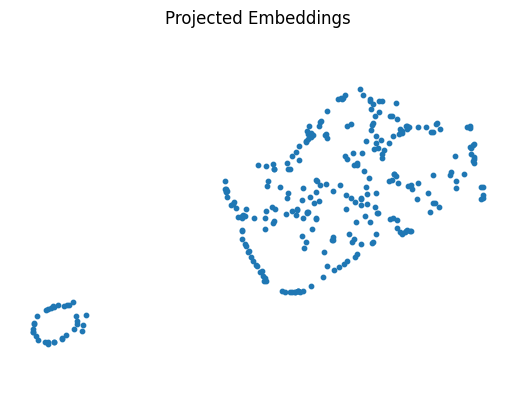

In [18]:
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off')

Relevancy and Distraction

In [35]:
query = "Under what circumstances and to what extent the Sellers are responsible for a breach of representations and warranties?"

results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

- 21 - 112923184 _ 5 provisions of the escrow agreement with the company securityholders being entitled to share in such released amounts in accordance with their pro rata percentages. from and after the closing, buyer and the sellers ’ representative will direct the escrow agent to disburse payments from the escrow account in accordance with the purchase price adjustment provisions of this agreement and the terms of the escrow agreement including : ( a ) in the case of any disbursement that is required by the terms of this agreement and as to which there is no dispute ( or as to which the disputing party has failed to notify the escrow agent and the other parties of its dispute in accordance with any applicable requirements under this agreement and the escrow agreement ), they will provide prompt joint payment instructions directing the escrow agent to make such disbursement and ( b ) in the case of a disbursement as to which either the buyer or the

of the amount, if any, by which su

In [20]:
output_answer = chom.openai_model_answer(query=query, retrieved_documents=retrieved_documents)
print(output_answer)

The Sellers are responsible for a breach of representations and warranties if it is due to the Sellers’ representative's gross negligence, bad faith, or willful misconduct. The Sellers' representative is allowed to rely on advice from counsel, public accountants, or other independent experts, and will not be liable for any actions taken in good faith based on such advice. Each Seller will individually indemnify the Sellers’ representative for any losses arising from serving in that capacity, except for losses due to gross negligence, bad faith, or willful misconduct. The Sellers’ representative is not personally liable for any obligations of the Sellers under the agreement.


In [21]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


(-0.21611873358488087,
 13.757389019429684,
 3.3563713669776916,
 11.264882838726043)

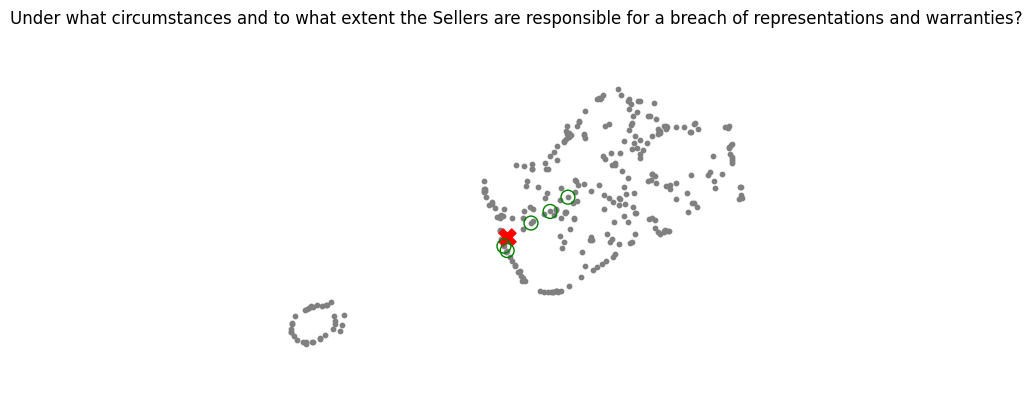

In [22]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

In [36]:
query = "How much is the escrow amount in value?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

- 21 - 112923184 _ 5 provisions of the escrow agreement with the company securityholders being entitled to share in such released amounts in accordance with their pro rata percentages. from and after the closing, buyer and the sellers ’ representative will direct the escrow agent to disburse payments from the escrow account in accordance with the purchase price adjustment provisions of this agreement and the terms of the escrow agreement including : ( a ) in the case of any disbursement that is required by the terms of this agreement and as to which there is no dispute ( or as to which the disputing party has failed to notify the escrow agent and the other parties of its dispute in accordance with any applicable requirements under this agreement and the escrow agreement ), they will provide prompt joint payment instructions directing the escrow agent to make such disbursement and ( b ) in the case of a disbursement as to which either the buyer or the

of the amount, if any, by which su

In [24]:
output_answer = chom.openai_model_answer(query=query, retrieved_documents=retrieved_documents)
print(output_answer)

The escrow amount mentioned in the annual report is $1,000,000.


In [25]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


(-0.21611873358488087,
 13.757389019429684,
 3.3563713669776916,
 11.264882838726043)

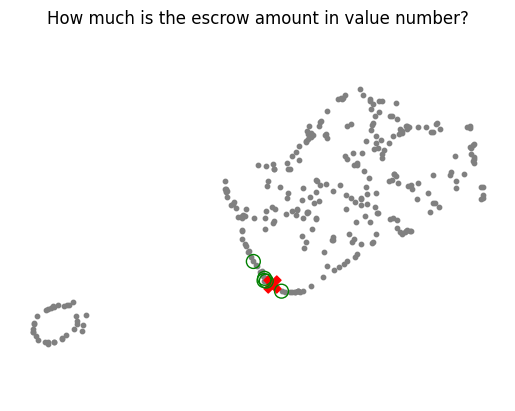

In [26]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

In [27]:
query = "How much is the escrow amount?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

- 21 - 112923184 _ 5 provisions of the escrow agreement with the company securityholders being entitled to share in such released amounts in accordance with their pro rata percentages. from and after the closing, buyer and the sellers ’ representative will direct the escrow agent to disburse payments from the escrow account in accordance with the purchase price adjustment provisions of this agreement and the terms of the escrow agreement including : ( a ) in the case of any disbursement that is required by the terms of this agreement and as to which there is no dispute ( or as to which the disputing party has failed to notify the escrow agent and the other parties of its dispute in accordance with any applicable requirements under this agreement and the escrow agreement ), they will provide prompt joint payment instructions directing the escrow agent to make such disbursement and ( b ) in the case of a disbursement as to which either the buyer or the

of the amount, if any, by which su

In [28]:
output_answer = chom.openai_model_answer(query=query, retrieved_documents=retrieved_documents)
print(output_answer)

The escrow amount mentioned in the annual report is to be deposited by the buyer at closing. This amount is to be held in a separate account called the "escrow account" and will be governed by the terms of the escrow agreement. All funds in the escrow account are to be available solely for the purpose of satisfying obligations of the company securityholders as provided in the agreement. The exact amount of the escrow is not specified in the provided information.


In [29]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


(-0.21611873358488087,
 13.757389019429684,
 3.3563713669776916,
 11.264882838726043)

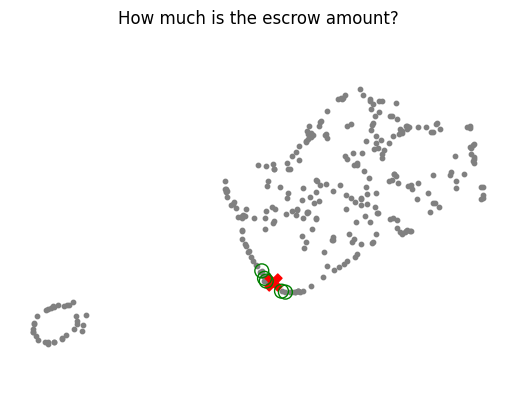

In [30]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

In [31]:
query = "Are there any conditions to the closing?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

annual basis, such as the deduction for depreciation ( other than with respect to property placed in service after the closing ), shall be apportioned on a daily basis and taxes that are computed on a periodic basis, such as property taxes shall also be apportioned on a daily basis. section 9. 05 intended u. s. tax treatment. [ ] 20. article x survival ; recourse limitations section 10. 01 survival. the representations and warranties of the parties contained in this agreement shall terminate automatically as of the closing, and no party or any of its affiliates or its or their respective representatives will have any recourse against the other party or any of its affiliates or its or their respective representatives with respect to such representations, warranties, covenants and agreements. the covenants and agreements contained in this agreement that are to be performed after the closing will survive the closing in

- 16 - 112923184 _ 5 section 2. 02 purchase price. in consideration f

In [32]:
output_answer = chom.openai_model_answer(query=query, retrieved_documents=retrieved_documents)
print(output_answer)

Based on the information provided from the annual report, one of the conditions to the closing is that the representations and warranties of the parties contained in the agreement will terminate automatically as of the closing. However, the covenants and agreements that are to be performed after the closing will survive the closing.


In [33]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


(-0.21611873358488087,
 13.757389019429684,
 3.3563713669776916,
 11.264882838726043)

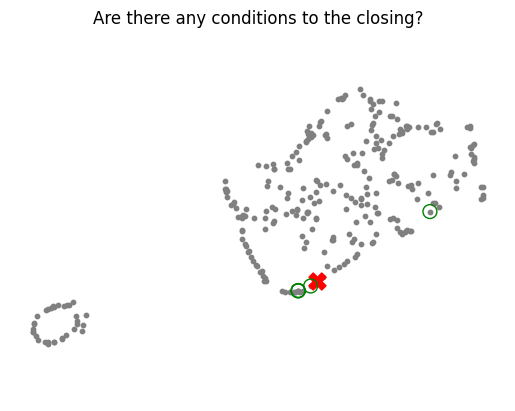

In [34]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')